# Example Solutions for E3

This notebook contains example solutions to <a href="E3 — Exercises on the Cell Membrane.ipynb">E3 — Exercises on the Cell Membrane</a>. 

Quicklinks
* [Exercise 1: A simple voltage clamp model](#1)
* [Exercise 2: Calculating Nernst Potentials](#2)
* [Exercise 3: The Equilibrium Membrane Potential](#3)
* [Exercise 4: A super simple action potential model](#4)

### Exercise 0: How thin is the cell membrane?

The major thing to get right here is to be consistent with the units. The computation itself is not very important, we are just looking for a ballpark estimate.

In [1]:
for case, radius, width in (('Apple', 35, 150e-3),
                            ('Earth', 6400, 25),
                            ('Cell', 10, 5e-3)):
    
    print(f"Relative width of {case}'s exterior: {width/radius:.3%}")

Relative width of Apple's exterior: 0.429%
Relative width of Earth's exterior: 0.391%
Relative width of Cell's exterior: 0.050%


We see that the three exteriors are all super thin compared to the radius, but especially so for the cell membrane, which is on the order of a magnitude thinner than the apple's skin or the earth's crust.

<a id="1"></a>
### Exercise 1: A simple voltage clamp model

**Exercise 1a) Implementing the target potential**

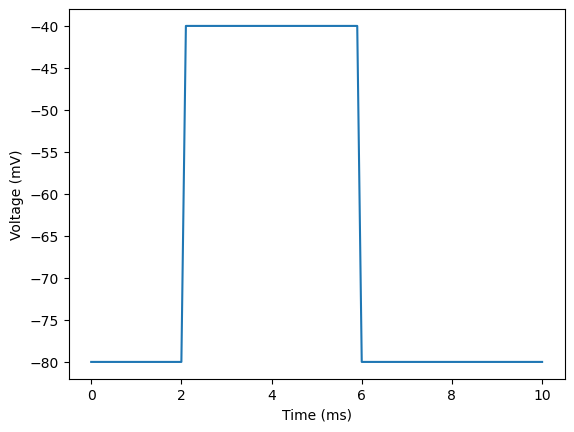

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def V_target(t):
    return -80 + 40*(t > 2)*(t < 6)

t = np.linspace(0, 10, 101)

plt.plot(t, V_target(t))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

**Exercise 1b) Checking the units**

$$\frac{{\rm d}V}{{\rm d}t} = \frac{V_{\rm target} - V}{C_{\rm m} R_{\rm s}}.$$

We start by looking at the denominator, as we are computing $V_{\rm target} - V$ these must be the same units, and we want to use millivolts here, mV. 

For the numerator we compute the product of $C_{\rm m}$, which is in nF, and $R_{\rm s}$, which is in M$\Omega$, then the product $C_{\rm m}R_{\rm s}$ will be millisecond, ms. If you think these unit computations are tricky, you can for example use Wolfram Alpha to double check.

The RHS is now mV over ms, and if we let our time also be given in milliseconds, this is consistent with our choice of measuring the membrane potential in mV. Therefore, no changes or scaling needs to be performed.

**Exercise 1c) Solving the ODE numerically**

Note: Because we have implemented `V_target` as a Python-function, we can call it from inside RHS, we then "pass along" the time-argument, which the `rhs` function already needs to take as an argument for `solve_ivp` to work. You could of course alternatively simply define the `V_target` value inside the `rhs`-function — but then we would not have the option to plot it out.

In [2]:
def rhs(t, V, Cm, Rs):
    dV_dt = (V_target(t) - V)/(Cm*Rs)
    return dV_dt

In [3]:
# Define time array
time = (0, 10)

# Define parameters
Cm = 0.05 # nF
Rs = 10 # MOhm
params = (Cm, Rs)

# Define initial condition
y0 = (-80,)

# Call odeint
solution = solve_ivp(rhs, time, y0, args=params, max_step=0.1)

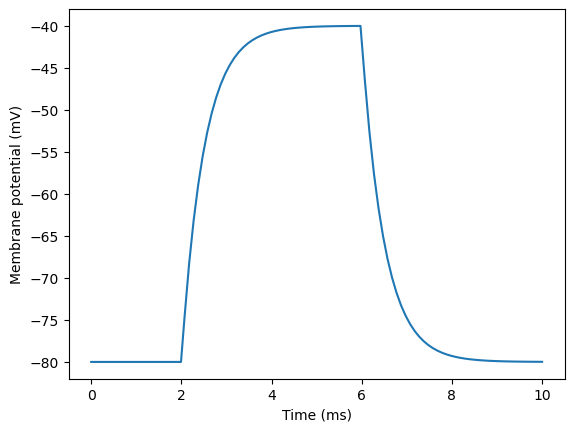

In [4]:
# Plot Solution
t = solution.t
V, = solution.y

plt.plot(t, V)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.show()

**Exercise 1d) Analyzing the solution**

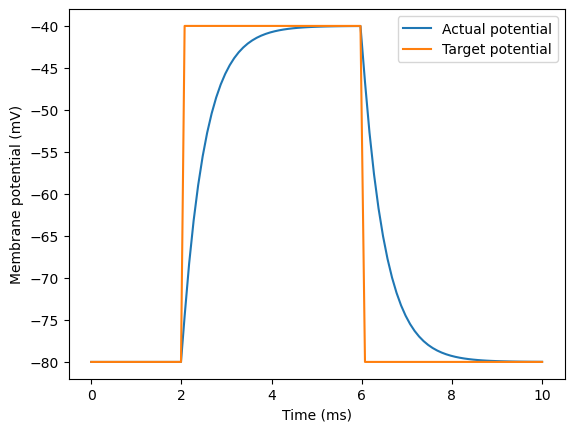

In [5]:
plt.plot(t, V, label='Actual potential')
plt.plot(t, V_target(t), label='Target potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()

**Explanation:** We see that the membrane potential $V$ does follow the target potential, but with a substantial delay. While the target is a step change, i.e., instantaneous change, the membrane potential needs time to copy this change. The shape of the actual potential is what we call an *exponential relaxation* towards the target potential.

**(Optional) Exercise 1e) Finding the analytical solution**


There are different ways to solve ODEs analytically. In this case we will be solving the differential equation with Laplace Transforms, but feel free to use any other method and you should end up with the same solution. 

We will solve the following ODE analytically

$$\frac{{\rm d}V}{{\rm d}t} = \frac{V_{\rm target} - V}{C_{\rm m} R_{\rm s}}.$$

We take the Laplace transform on both the left and right side of the equation: 

$$\mathcal{L}\left(\frac{{\rm d}V}{{\rm d}t}\right) = s\cdot V(s) - V(0)$$


$$\mathcal{L}\left(\frac{V_{\rm target} - V}{C_{\rm m} R_{\rm s}}\right) = \frac{V_{\rm target}(s) - V(s)}{C_{\rm m} R_{\rm s}}$$

Thus, we can write

$$ s V(s) - V(0) = \frac{V_{\rm target}(s) - V(s)}{C_{\rm m} R_{\rm s}}$$

We can now multiply by $C_{\rm m} R_{\rm s}$ and obtain
$$ s C_{\rm m} R_{\rm s} V(s) - C_{\rm m} R_{\rm s} V(0) = V_{\rm target}(s) - V(s)
$$

Bring $V(s)$ to the left side of the equation and $V(0)$ to the right side of the equation

$$ s C_{\rm m} R_{\rm s} V(s) + V(s) = V_{\rm target}(s) + C_{\rm m} R_{\rm s} V(0)
$$

$$ (s \cdot C_{\rm m} R_{\rm s} + 1) \cdot V(s) = V_{\rm target}(s) + C_{\rm m} R_{\rm s} V(0)
$$

We divide now by $(s \cdot C_{\rm m} R_{\rm s} + 1)$ to obtain an expression for $V(s)$

$$  V(s) = \frac{V_{\rm target}(s)}{s \cdot C_{\rm m} R_{\rm s} + 1} + \frac{C_{\rm m} R_{\rm s} V(0)}{s \cdot C_{\rm m} R_{\rm s} + 1}
$$

This expression can also be rewritten in a slightly different way, which will be helpful for calculating the inverse Laplace transform

$$  V(s) = \frac{1}{C_{\rm m} R_{\rm s}} \cdot \frac{V_{\rm target}(s)}{s + \frac{1}{C_{\rm m} R_{\rm s}}} + \frac{V(0)}{s +  \frac{1}{C_{\rm m} R_{\rm s}}}
$$

With the help of inverse Laplacian transform properties 

$$\mathcal{L}^{-1}\left(\frac{1}{\rm s + a}\right) = e^{-\mathrm{a}t}$$

$$\mathcal{L}^{-1}\left(F(s)\cdot G(s)\right) = \int_{0}^{t} f(u)\cdot g(t-u) \, du$$

we can calculate the inverse laplacian of our different terms 

$$\mathcal{L}^{-1}\left(\frac{V(0)}{s +  \frac{1}{C_{\rm m} R_{\rm s}}}\right) = V(0) \cdot e^{-\frac{t}{C_{\rm m} R_{\rm s}}}$$


$$\mathcal{L}^{-1}\left(\frac{V_{\rm target}(s)}{s + \frac{1}{C_{\rm m} R_{\rm s}}}\right) = \int_{0}^{t} V_{\rm target}(u)\cdot e^{-\frac{t - u}{C_{\rm m} R_{\rm s}}} \, du = e^{-\frac{t}{C_{\rm m} R_{\rm s}}} \cdot\int_{0}^{t} V_{\rm target}(u)\cdot e^{\frac{u}{C_{\rm m} R_{\rm s}}} \, du$$


and obtain an analytical solution for our ODE

$$V(t) = V(0) \cdot e^{-\frac{t}{C_{\rm m} R_{\rm s}}} + \frac{1}{C_{\rm m} R_{\rm s}} \cdot e^{-\frac{t}{C_{\rm m} R_{\rm s}}} \cdot\int_{0}^{t} V_{\rm target}(u)\cdot e^{\frac{u}{C_{\rm m} R_{\rm s}}} \, du$$


Since $V_{\rm target}$ is a piecewise constant function we need to consider the limits of the pieciwise function when integrating the solution. 

By plotting the analytical solution we can see it matches our calculated numerical solution.

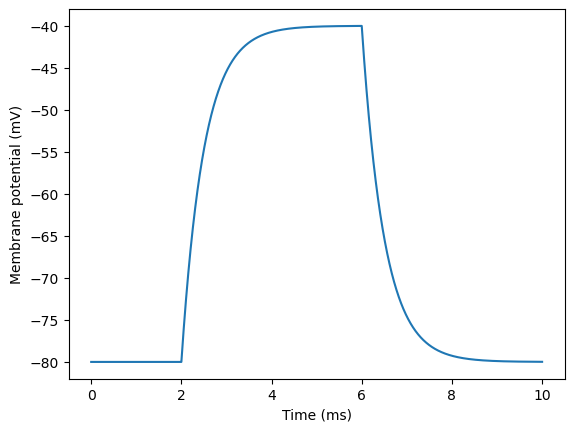

In [9]:
t = solution.t
V, = solution.y

V_a = []
t = np.linspace(0, 10, 10000)

for idx, i in enumerate(t):
    if i < 2:
        V_a.append(-80*np.exp(-i/(Cm*Rs)) + np.exp(-i/(Cm*Rs))*(np.exp(i/(Cm*Rs))*-80 - -80))
    elif i>2 and i<6:
        V_a.append(-80*np.exp(-i/(Cm*Rs)) + np.exp(-i/(Cm*Rs))*(np.exp(i/(Cm*Rs))*-40 - np.exp(2/(Cm*Rs))*-40 + np.exp(2/(Cm*Rs))*-80 - np.exp(0/(Cm*Rs))*-80))
    else:
        V_a.append(-80*np.exp(-i/(Cm*Rs)) + np.exp(-i/(Cm*Rs))*(np.exp(i/(Cm*Rs))*-80 - np.exp(6/(Cm*Rs))*-80 + np.exp(6/(Cm*Rs))*-40 - np.exp(2/(Cm*Rs))*-40 + np.exp(2/(Cm*Rs))*-80 - np.exp(0/(Cm*Rs))*-80))
        
plt.plot(t, V_a)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.show()

**Exercise 1f) Playing around with the model parameters (Widget)**

If you play around with the widget, you might notice that the voltage follows the prescribed voltage more closely the smaller the membrane capacitance and/or series resitance is. In fact, it is the product of the two that is important, as this is the characteristic time constant of the membrane response:
$$\tau = C_{\rm m}\cdot R_{\rm s}.$$ 
If you solved (1e) you might have noticed this already. Simply put, the model says that the actual membrane potential will approach the prescribed potential as an exponential relaxation, with a relaxation time of $\tau$. If $\tau$ is big, we will need to wait a long time for it to reach the prescribed value.

For a whole cell voltage clamp protocol, the cell membrane capacitance is typically 0.05 nF, and the series resistance is usually in the range 5-20 M$\Omega$. This gives a noticeable delay in the membrane potential response, and capacitive currents that persist over several milliseconds. This can actually disturb the measurement of other currents, introducing noise.

In another technique, the 'patch' clamp, a small patch of the membrane is torn of (1 µm$^2$). This means the capacitance, $C_{\rm m}$ is drastically lowered ($\sim0.01$ pF). In a patch clamp, the series resistance is usually in the G$\Omega$ range, so the time constant becomes very small, and there are usually little noise due to the capacitive currents.

<a id="2"></a>
### Exercise 2: Calculating Nernst Potentials

**Exercise 2a) Computing the Nernst potentials**

In [7]:
F = 96485 # C/mol
R = 8.314 # J/(mol K)
T = 310   # K

E_Na = R*T/F * np.log(110/8)
E_K = R*T/F * np.log(4/100)
E_Ca = R*T/(2*F) * np.log(1/0.0002)

E_Na *= 1e3
E_K *= 1e3
E_Ca *= 1e3

print(f"Equilibrium potential for Na: {E_Na:5.1f} mV")
print(f"Equilibrium potential for K:  {E_K:5.1f} mV")
print(f"Equilibrium potential for Ca: {E_Ca:5.1f} mV")

Equilibrium potential for Na:  70.0 mV
Equilibrium potential for K:  -86.0 mV
Equilibrium potential for Ca: 113.8 mV


**Exercise 2b) Interpreting the sign of the Nernst Potential**


Looking at the concentrations of the three ions. We see that there is a large inward concentration gradient for sodium and calcium, which is why their Nernst potentials are positive, because a higher potential inside than outside will balance out the inward concentration gradient. For potassium however, the concentration gradient is the other direction, so we need to have a potential difference in the other direction to balance this gradient, which is why we get a negative potential in that case.

**Exercise 2c) How much current is needed to charge the membrane?**

In [8]:
Cm = 0.05 # nF
dV = 120 # mV
dQ = Cm*dV

print(f"Approximately {dQ:.1f} pC travels through the membrane.")

Approximately 6.0 pC travels through the membrane.


6 *pico*coloumb is an absolutely tiny current. Of course, the cell is also tiny, so it is a bit hard to interpret this answer in relative terms.

**Exercise 2d) Number of particles**

We now find the number of ions $6.0$ pC corresponds to. Using Faraday's constant, we find

In [9]:
F = 96485 # C/mol
dNa = dQ/F
print(f"Roughly {dNa:.1g} picomols pass through the membrane.")

Roughly 6e-05 picomols pass through the membrane.


Again the number *seems* super small, but it is a bit hard to interpret.

**Exercise 2e) Change in concentration**

In [10]:
V = 20 # picoliters
dconc = dNa/V*1e3
rel = 1 - (8-dconc)/8 # Relative change in intracellular sodium

print(f"Absolute concentration change: {dconc:.4f} mM")
print(f"Relative concentration change: {rel:.3%}")

Absolute concentration change: 0.0031 mM
Relative concentration change: 0.039%


Now we have arrived at a relative measure, and we see the change in concentration is on the order of a hundreth of a percent, which is an absolutelty tiny change in the cells concentration.

**Exercise 2f) Perturbing the Nernst potential**

In [11]:
E_Na = R*T/F * np.log(110/8)
E_Na *= 1e3
print(f"Original E_Na:              {E_Na:.1f} mV")

E_Na = R*T/F * np.log(110/(1.3*8))
E_Na *= 1e3
print(f"After 30% increase in Na:   {E_Na:.1f} mV")

Original E_Na:              70.0 mV
After 30% increase in Na:   63.0 mV


So we see the Nernst potential shifts about 7 mV with these numbers. If you find this surprising, notice that the 30% increase only applies inside the logarithm, and thus it will affect the final answer less than one might expect.

**Exercise 2g) Is the Nernst potential a constant? (Discuss)**

These calculations shows that
1. The ion concentration of sodium changes very little, even with a big change in membrane potential
2. Even a big change in ion concentrations lead to relatively small changes in the Nernst potential.

Taken together, these two findings argue for the fact that one can consider the Nernst potential to be as good as constant, even though it depends directly on concentrations that do change a bit throughout an action potential. In practice one typically consider Nernst potentials to be constant in action potential models. The one major exception to this is calcium, which has such a low initial intracellular concentration that the relative change can be as much as a thousandfold increase in concentration. In these cases it might be worth actively updating the Nernst potential throughout the action potential. We will get back to why the calcium concentration is so different from the other species later in the course.

<a id="3"></a>
### Exercise 3: The Equilibrium Membrane Potential

**Exercise 3a) Solve the model in Python**

We will solve the following ODE numerically
$$C_{\rm m}\frac{{\rm d}V}{{\rm d}t} = - g_{\rm Na} (V-E_{\rm Na}).$$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE
def rhs(t, V, Cm, g_Na, E_Na):
    dV_dt = -g_Na*(V - E_Na)/Cm
    return dV_dt

# Define the parameters and initial condition
T = (0, 100)
Cm = 0.05 # nF
E_Na = 70 # mV (Copied from computation in previous exercise)
g_Na = 0.005 # µS
params = (Cm, g_Na, E_Na)
y0 = (-80,) # mV

# Solve the ODE
solution = solve_ivp(rhs, T, y0, args=params, max_step=0.1)

t = solution.t
V, = solution.y

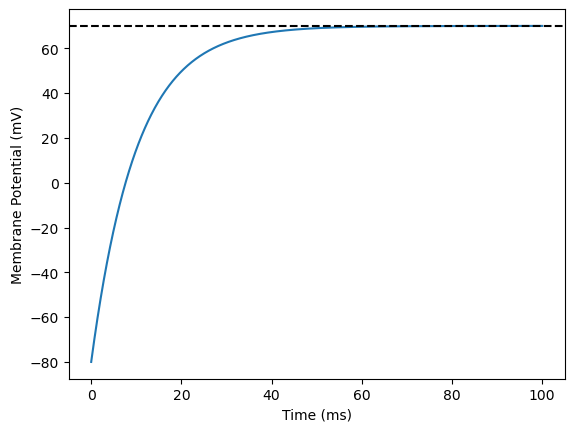

In [13]:
plt.plot(t, V)
plt.axhline(E_Na, linestyle='--', color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.show()

**Exercise 3b) Analyzing the solution**

The membrane potential stabilizes at 70 mV, which is our value for $E_{\rm Na}$. For our chosen parameters we see that it takes roughly 25–50 ms til reach this value. Though the shape is an exponential relaxation, so it is impossible to set an exact value where the potential has "equilibriated".

**(Optional) Exercise 3c) Analytical Solution**

We now solve the ODE analytically. It is almost identical to what we solved earlier, and we carry out the same process. First we substitute $u = V-E_{\rm Na}$ to find:
$$\frac{1}{u} \frac{{\rm d}u}{{\rm d}t} = -\frac{g_{\rm Na}}{C_{\rm m}}.$$
Which is a separabel ODE, so we get
$$u(t) = Ce^{-t\cdot g_{\rm Na}/C_{\rm m}}.$$
So we get
$$V(t) = E_{\rm Na} + (V_0 - E_{\rm Na})e^{-t/\tau},$$
where $\tau = g_{\rm Na}/C_{\rm m}$. So we see the solution is an exponential decay to the Nernst potential, with a time constant of $g_{\rm Na}/C_{\rm m}$. Thus, the bigger the conductance of the channels, the bigger the current, and the faster the change in potential, and the bigger the capacitance, the harder it is to change the membrane potential, so it takes longer.

For our parameters we have

$$\tau = \frac{g_{\rm Na}}{C_{\rm m}} = \frac{0.005 {\rm\ µS}}{0.05 {\rm\ nF}} = 10 {\rm\ ms}.$$

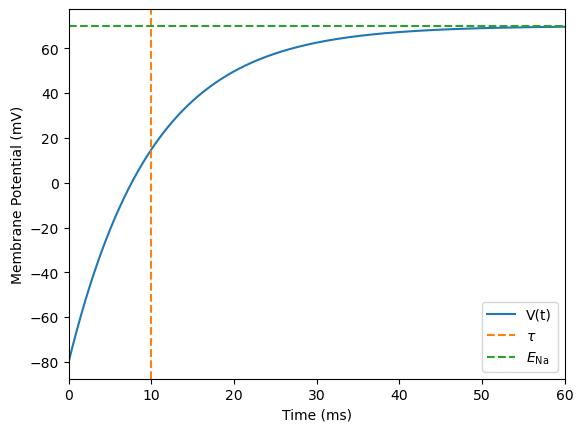

In [14]:
plt.plot(t, V, label=r'V(t)')
plt.axvline(10, linestyle='--', color='C1', label=r'$\tau$')
plt.axhline(E_Na, linestyle='--', color='C2', label=r'$E_{\rm Na}$')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.xlim(0, 60)
plt.legend()
plt.show()

**Exercise 3d) Adding more currents**

We copy our code from above, and add the two new currents

In [15]:
# Define the ODE
def rhs(t, V, Cm, g_Na, g_K, g_Ca, E_Na, E_K, E_Ca):
    dV_dt = -(g_Na*(V - E_Na) + g_K*(V - E_K) + g_Ca*(V - E_Ca))/Cm
    return dV_dt

# Define the parameters and initial condition
T = (0, 50)
Cm = 0.05 # nF
g_Na = 0.005 # µS
g_K = 0.05 # µS
g_Ca = 0.002 # µS
params = (Cm, g_Na, g_K, g_Ca, E_Na, E_K, E_Ca)
y0 = (0,) # mV

# Solve the ODE
solution = solve_ivp(rhs, T, y0, args=params, max_step=0.1)

t = solution.t
V, = solution.y

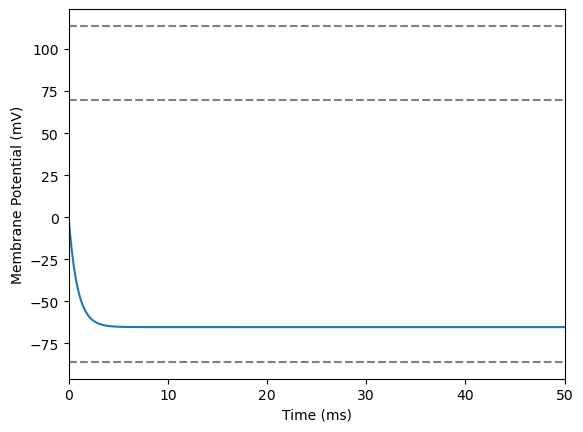

In [16]:
plt.plot(t, V)
plt.axhline(E_Na, linestyle='--', color='grey')
plt.axhline(E_Ca, linestyle='--', color='grey')
plt.axhline(E_K, linestyle='--', color='grey')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.xlim(0, 50)
plt.show()

**Exercise 3e) Analyzing the solution**

From the plot we can see that the equilibrium looks to be about -65 mV. If we want to write it out, we can read out the last value of the `V` variable, which is a numpy array, using negative indexing let's us read the last element:

In [17]:
print(f"Equilibrium potential: {float(V[-1]):.1f} mV")

Equilibrium potential: -65.3 mV


Rerunning with a different initial condition shows us that the equilibrium does not change.

The equilibrium potential becomes -65 mV in this case, because this is a balancing point between the three currents. Each current individually wants to membrane potential to be equal to their Nernst potential, so the sodium and calcium currents are pulling $V$ upwards, while the potassium current  is pulling it down. Because we have set the potassium current to be so much stronger $g_{\rm K} \gg g_{\rm Na} \approx g_{\rm Ca}$, we see that it wins this "tug-of-war" and the equilibrium lies close to the Nernst potential for potassium.


**Exercise 3f) Resting membrane potential (Widget exercise)**

Playing around with the widget we find that we must max out the potassium conductance ($g_{\rm K} = 25-30$ µS) and minimize the calcium and sodium conductances (for example $g_{\rm Na} =1$ µS and $g_{\rm Ca}=0$ µS), to end up at -80 mV.

This shouldn't be too surprising, as -80 mV is very close to the Nernst potential for potassium, meaning potassium should be absolutely dominating when the cell is at rest. In practice we find that the potassium conductance at rest is indeed about 25-fold that of the combined sodium and calcium conductances. This is because there are open potassium channels at rest, while calcium and sodium channels tend to be closed at rest.

<a id="4"></a>
### Exercise 4: A super simple action potential model

#### Exercise 4a) Solving the System

We now solve the ODE
$$C_{\rm m}\frac{{\rm d}V}{{\rm d}t} = -g_{\rm Na} (V-E_{\rm Na}) - g_{\rm K} (V-E_{\rm K}).$$
With a time dependent sodium conductance:
$$g_{\rm Na}(t) = \begin{cases}
0.75 {\rm\ µS} & \mbox{if } 2 {\rm\ ms} < t < 2.2 {\rm\ ms}, \\
0.003 {\rm\ µS} & \mbox{else.}
\end{cases}$$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [19]:
# Define the ODE
def rhs(t, V, Cm, g_K, E_Na, E_K):
    g_Na = 0.55 if (2 < t < 2.2) else 0.003
    dV_dt = (-g_Na*(V-E_Na) - g_K*(V-E_K))/Cm
    return dV_dt

# Define the parameters and initial condition
T = (0, 10)
Cm = 0.05 # nF
g_K = 0.075 # µS
params = (Cm, g_K, E_Na, E_K)
y0 = (-80,) # mV

# Solve the ODE
solution = solve_ivp(rhs, T, y0, args=params, max_step=0.1)

t = solution.t
V, = solution.y

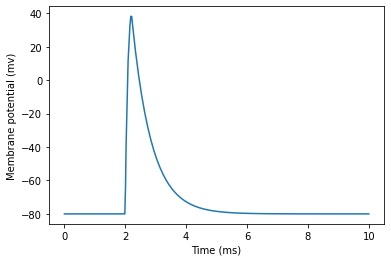

In [20]:
plt.plot(t, V)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mv)')
plt.show()

#### Exercise 4b) Analyzing the result


We see that before $t=2$ ms, the cell is resting with a membrane potential at around -80 mV. At $t=2$ ms, the sodium channels open and we see a very rapid increase in the membrane potential. This is because the balance between the inward sodium current and the outward potassium current has been dramatically shifted.

While the sodium current would like to approach the Nernst potential for sodium at around +70 mV, the membrane is not given enough time to do this. Instead, at $t=2.2$ ms, the channels close again. This means that the balance is again shifted to the stronger potassium current, and the membrane potential drops down to its resting membrane potential at around -80 mV.

The membrane potential is always driven by passive ion transport, i.e., electrodiffusion. The underlying driving force therefore never changes. The only changes over time is what channels are open, i.e., what ions are permitted to diffuse through the membrane.

#### Discussion

Here we have created a very simple model of an action potential, by saying that at some time sodium channels open and stay open for a short, fixed, duration. While this is a gross simplification of how sodium channels work, it is actually produces an action potential that is phenomenologically quite correct. At least for neuronal action potentials which last on the order of milliseconds. In cardiac cells, action potentials last for a few hundred milliseconds. You will understand why this is the case better when we get further in the course.